In [1]:
import pickle
from collections import defaultdict
from matplotlib import pyplot as plt
import numpy as np
import itertools
import tqdm
from sklearn.metrics import f1_score

### MathOverflow

In [2]:
data_type = 'mathoverflow'
max_tag_list = 1554

In [3]:
answerer_info_dict = defaultdict(list)  # {answerer: [q1, q3, ..., qn]}
question_info_dict = defaultdict(list)  # {question: [a2, a5, ..., an]}

# 1. Build answerer_info_dict & question_info_dict
with open(data_type+'/answerer_info_'+data_type+'.txt') as f:
    answerer_info = f.read()
answerer_info = answerer_info.split('\n')[:-1]
for answerer_idx, questions in enumerate(answerer_info):
    questions = list(map(int, questions.split(' ')))
    answerer_info_dict[answerer_idx] = questions
    for question in questions:
        question_info_dict[question].append(answerer_idx)
        
print(len(answerer_info_dict))
print(len(question_info_dict))

5446
73851


### No. of answerers per question

In [4]:
x = []
for answerers in question_info_dict.values():
    x.append(len(answerers))
max(x)

173

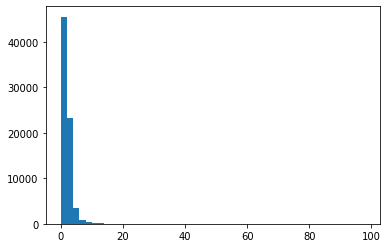

In [5]:
plt.hist(np.array(x), bins=np.arange(50)*2)
plt.show()

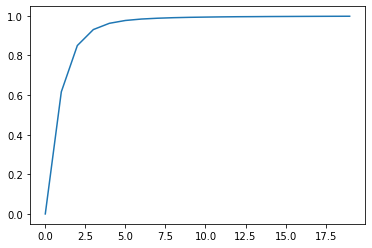

[0.         0.61618665 0.84979215 0.93049519 0.96203166 0.97633072
 0.9835615  0.98766435 0.99037251 0.99218697 0.9933921  0.99447536
 0.99526073 0.99566695 0.99620858 0.99653356 0.99689916 0.9972106
 0.99746787 0.99768453]


In [6]:
hist, bins = np.histogram(x, bins=np.arange(173))
cdf = np.cumsum(hist) / len(question_info_dict)
plt.plot(np.arange(20), cdf[:20])
plt.show()
print(cdf[:20])

### No. of questions per answerer

In [7]:
x = []
for questions in answerer_info_dict.values():
    x.append(len(questions))
max(x)

1784

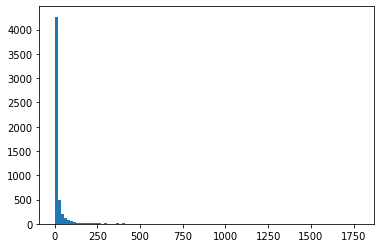

In [8]:
plt.hist(np.array(x), bins=np.arange(100)*18)
plt.show()

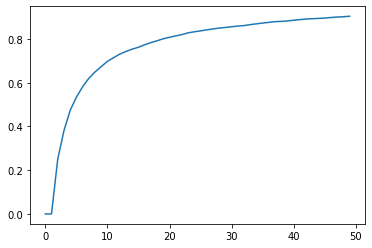

[0.         0.         0.24972457 0.38009548 0.47300771 0.53341902
 0.58097686 0.61953728 0.64891664 0.67352185 0.69739258 0.71446934
 0.7308116  0.74293059 0.75358061 0.76184355 0.7735953  0.78295997
 0.79177378 0.80077121 0.80756519 0.81399192 0.81968417 0.82794712
 0.83272126 0.83694455 0.84153507 0.84575835 0.8496144  0.85255233
 0.85585751 0.85879545 0.86118252 0.8654058  0.86907822 0.87256702
 0.8758722  0.87899376 0.8802791  0.88229893 0.88560411 0.88835843
 0.89111274 0.89258171 0.89386706 0.89533603 0.89809034 0.90011017
 0.90139552 0.90378259]


In [9]:
hist, bins = np.histogram(x, bins=np.arange(1784))
cdf = np.cumsum(hist) / len(answerer_info_dict)
plt.plot(np.arange(50), cdf[:50])
plt.show()
print(cdf[:50])

### No. of tags per question (train)

In [10]:
with open(data_type+'/train_answer_'+data_type+'.txt') as f:
    train_answer = f.read()

train_answer = train_answer.split('\n')[:-1]
train_answer_dict = {}
tags_list = []
for answer_idx, tags in enumerate(train_answer):
    tags = list(map(int, tags.split(' ')))
    train_answer_dict[answer_idx] = tags
    tags_list += tags

print(len(train_answer_dict))
print(len(set(tags_list)))

59080
1429


In [11]:
x = []
for tags in train_answer_dict.values():
    x.append(len(tags))
max(x)

5

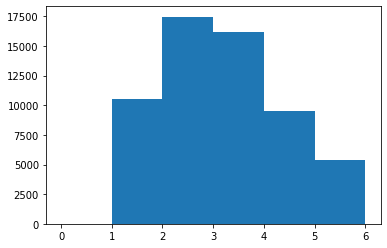

In [12]:
plt.hist(np.array(x), bins=np.arange(7))
plt.show()

In [13]:
with open(data_type+'/train_query_'+data_type+'.txt') as f:
    train_query = f.read()
train_query = train_query.split('\n')[:-1]
    
x = []
overlap = []
for questions in tqdm.tqdm(answerer_info_dict.values()):
    tag_list = []
    for question in questions:
        if str(question) in train_query:
            tag_list.append(train_answer_dict[train_query.index(str(question))])
    tag_list = list(itertools.chain.from_iterable(tag_list))
    distinct_tag_list = set(tag_list)
    
    if len(tag_list) > 0:
        x.append(len(distinct_tag_list))
        overlap.append(len(distinct_tag_list)/len(tag_list))
print(max(x))
print(1 - np.mean(overlap))

100%|██████████| 5446/5446 [01:20<00:00, 67.68it/s] 

521
0.27423497244137385


### Baseline

In [14]:
with open(data_type + '.pickle', 'rb') as f:
    data = pickle.load(f)

question_info_dict = data['question_info_dict']
answerer_info_dict = data['answerer_info_dict']
question_to_tags = data['question_to_tags']
val_data = data['val']
val_query = val_data['question_idxes']
val_label = val_data['labels']

In [15]:
f1_dict = defaultdict(list)
y_pred_list = []
y_true_list = []
for idx, question_idx in tqdm.tqdm(enumerate(val_query)):
    labels = val_label[idx]
    tag_list = []
    answerers = question_info_dict[question_idx]
    for answerer in answerers:
        question_from_answerer = answerer_info_dict[answerer]
        for question in question_from_answerer:
            if question in question_to_tags:
                tags = question_to_tags[question]
                tag_list.append(tags)
                
    tag_list = list(itertools.chain.from_iterable(tag_list))
    y_pred = np.zeros(max_tag_list+100)
    for tag in tag_list:
        y_pred[tag] += 1
    
    y_true = np.zeros(max_tag_list+100)
    for tag in labels:
        y_true[tag] = 1
    
    y_pred_list.append(y_pred)
    y_true_list.append(y_true)

thresholds = np.arange(0, 100, 5)
for th in thresholds:
    f1 = f1_score(np.array(y_true_list), np.array(y_pred_list)>th, average='micro')
    print('th:%3d  f1:%.3f'%(th, f1))

7385it [00:03, 2005.40it/s]


th:  0  f1:0.027
th:  5  f1:0.103
th: 10  f1:0.143
th: 15  f1:0.164
th: 20  f1:0.182
th: 25  f1:0.193
th: 30  f1:0.194
th: 35  f1:0.194
th: 40  f1:0.192
th: 45  f1:0.189
th: 50  f1:0.184
th: 55  f1:0.179
th: 60  f1:0.176
th: 65  f1:0.173
th: 70  f1:0.167
th: 75  f1:0.161
th: 80  f1:0.158
th: 85  f1:0.152
th: 90  f1:0.145
th: 95  f1:0.140


### StackOverflow

In [16]:
data_type = 'stackoverflow'
max_tag_list = 65520

In [17]:
answerer_info_dict = defaultdict(list)  # {answerer: [q1, q3, ..., qn]}
question_info_dict = defaultdict(list)  # {question: [a2, a5, ..., an]}

# 1. Build answerer_info_dict & question_info_dict
with open(data_type+'/answerer_info_'+data_type+'.txt') as f:
    answerer_info = f.read()
answerer_info = answerer_info.split('\n')[:-1]
for answerer_idx, questions in enumerate(answerer_info):
    questions = list(map(int, questions.split(' ')))
    answerer_info_dict[answerer_idx] = questions
    for question in questions:
        question_info_dict[question].append(answerer_idx)
        
print(len(answerer_info_dict))
print(len(question_info_dict))

10509
119630


### No. of answerers per question

In [18]:
x = []
for answerers in question_info_dict.values():
    x.append(len(answerers))
max(x)

12

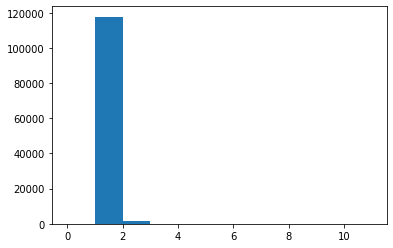

In [19]:
plt.hist(np.array(x), bins=np.arange(12))
plt.show()

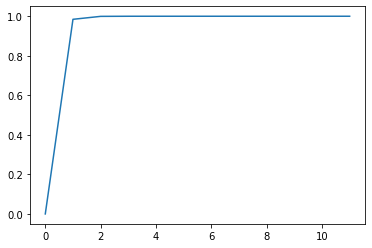

[0.         0.98449386 0.99938979 0.99994149 0.9999582  0.99998328
 0.99998328 0.99998328 0.99999164 0.99999164 0.99999164 1.        ]


In [20]:
hist, bins = np.histogram(x, bins=np.arange(13))
cdf = np.cumsum(hist) / len(question_info_dict)
plt.plot(np.arange(12), cdf[:12])
plt.show()
print(cdf[:12])

### No. of questions per answerer

In [21]:
x = []
for questions in answerer_info_dict.values():
    x.append(len(questions))
max(x)

1682

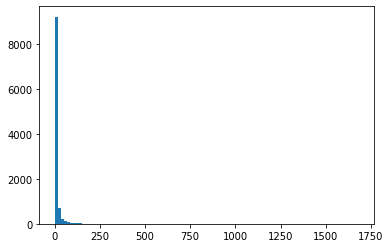

In [22]:
plt.hist(np.array(x), bins=np.arange(100)*17)
plt.show()

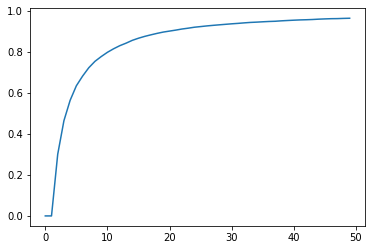

[0.         0.         0.30098011 0.46493482 0.56437339 0.63526501
 0.68236749 0.72337996 0.75478162 0.77790465 0.79874393 0.81606242
 0.83119231 0.84337235 0.85707489 0.86754211 0.87648682 0.88409934
 0.89123608 0.89761157 0.9023694  0.90712722 0.91245599 0.91654772
 0.92121039 0.92435056 0.92758588 0.93034542 0.93291464 0.93538871
 0.93786278 0.93995623 0.9424303  0.9446189  0.94604625 0.94775906
 0.94928157 0.95032829 0.95242173 0.95403939 0.9555619  0.95689409
 0.9577505  0.95889238 0.9606052  0.96184223 0.96288895 0.96326958
 0.9643163  0.96507755]


In [23]:
hist, bins = np.histogram(x, bins=np.arange(1682))
cdf = np.cumsum(hist) / len(answerer_info_dict)
plt.plot(np.arange(50), cdf[:50])
plt.show()
print(cdf[:50])

### No. of tags per question (train)

In [24]:
with open(data_type+'/train_answer_'+data_type+'.txt') as f:
    train_answer = f.read()

train_answer = train_answer.split('\n')[:-1]
train_answer_dict = {}
tags_list = []
for answer_idx, tags in enumerate(train_answer):
    tags = list(map(int, tags.split(' ')))
    train_answer_dict[answer_idx] = tags
    tags_list += tags
    
print(len(train_answer_dict))
print(len(set(tags_list)))
print(max(set(tags_list)))

95704
6792
55520


In [25]:
x = []
for tags in train_answer_dict.values():
    x.append(len(tags))
max(x)

6

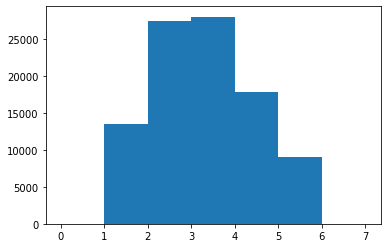

In [26]:
plt.hist(np.array(x), bins=np.arange(8))
plt.show()

### No. of tags per answerer

In [26]:
with open(data_type+'/train_query_'+data_type+'.txt') as f:
    train_query = f.read()
train_query = train_query.split('\n')[:-1]
    
x = []
overlap = []
for questions in tqdm.tqdm(answerer_info_dict.values()):
    tag_list = []
    for question in questions:
        if str(question) in train_query:
            tag_list.append(train_answer_dict[train_query.index(str(question))])
    tag_list = list(itertools.chain.from_iterable(tag_list))
    distinct_tag_list = set(tag_list)
    
    if len(tag_list) > 0:
        x.append(len(distinct_tag_list))
        overlap.append(len(distinct_tag_list)/len(tag_list))
print(max(x))
print(1 - np.mean(overlap))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10509/10509 [02:04<00:00, 84.36it/s]


1253

### Baseline

In [27]:
with open(data_type + '.pickle', 'rb') as f:
    data = pickle.load(f)

question_info_dict = data['question_info_dict']
answerer_info_dict = data['answerer_info_dict']
question_to_tags = data['question_to_tags']
val_data = data['val']
val_query = val_data['question_idxes']
val_label = val_data['labels']

In [ ]:
f1_dict = defaultdict(list)
y_pred_list = []
y_true_list = []
for idx, question_idx in tqdm.tqdm(enumerate(val_query)):
    labels = val_label[idx]
    tag_list = []
    answerers = question_info_dict[question_idx]
    for answerer in answerers:
        question_from_answerer = answerer_info_dict[answerer]
        for question in question_from_answerer:
            if question in question_to_tags:
                tags = question_to_tags[question]
                tag_list.append(tags)
                
    tag_list = list(itertools.chain.from_iterable(tag_list))
    y_pred = np.zeros(max_tag_list+100)
    for tag in tag_list:
        y_pred[tag] += 1
    
    y_true = np.zeros(max_tag_list+100)
    for tag in labels:
        y_true[tag] = 1
    
    y_pred_list.append(y_pred)
    y_true_list.append(y_true)

thresholds = np.arange(0, 100, 5)
for th in thresholds:
    f1 = f1_score(np.array(y_true_list), np.array(y_pred_list)>th, average='micro')
    print(th, f1)

11954it [00:04, 2685.15it/s]


0 0.010623258636122858
5 0.06549743163015474
10 0.0716363733418742
15 0.06971720345640219
20 0.06691449814126393
25 0.06422869871913867
30 0.06158199703543997
35 0.05428836346777933
40 0.05106321423405179
45 0.05042684137383363
